### Toy problem

See https://arxiv.org/pdf/1810.10667



In [13]:
import jax
import jax.numpy as jnp
import optax
from matplotlib import pyplot as plt

In [163]:
@jax.jit
def loss_fn_trn(w_params, h_params):
    G = jnp.diag(jnp.asarray([1, 0.5]))
    loss = (w_params - h_params) @ G @ (w_params - h_params)
    return loss

@jax.jit
def loss_fn_val(w_params, h_params):
    loss = (w_params ** 2).sum() + 10 * (jnp.sin(w_params) ** 2).sum()
    return loss


@jax.jit
def loss_fn_val_grad_params(w_params, h_params):
    return jax.grad(loss_fn_val, argnums=0)(w_params, h_params)


@jax.jit
def normalize(v):
    return jnp.sqrt(jax.tree_util.tree_reduce(lambda v, x: v + (x ** 2).sum(), v, 0))


@jax.jit
def inner_step(state):    
    grad_fn = jax.grad(loss_fn_trn, argnums=0)
    grads = grad_fn(state.w_params, state.h_params)
    state = state.apply_w_gradients(w_grads=grads)
    return state


@jax.jit
def B_jvp(w_params, h_params, state, v, r=1e-2):
    """d^2 L1 / dl dw v"""
    eps = r / normalize(v)
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dlam = jax.grad(loss_fn_trn, argnums=1)
    g_plus = dl_dlam(w_plus, h_params)
    g_minus = dl_dlam(w_minus, h_params)
    return jax.tree_util.tree_map(lambda x, y: -state.lr * (x - y) / (2 * eps), g_plus, g_minus)


@jax.jit
def A_jvp(w_params, state, v, r=1e-2):
    eps = r / normalize(v)
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dw = jax.grad(loss_fn_trn, argnums=0)
    g_plus = dl_dw(w_plus, state.h_params)
    g_minus = dl_dw(w_minus, state.h_params)
    hvp = jax.tree_util.tree_map(lambda x, y: (x - y) / (2 * eps), g_plus, g_minus)
    return jax.tree_util.tree_map(lambda x, y: x - state.lr * y, v, hvp)


def luketina_so_grad(state, T: int):
    """T = len(batches)"""
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    for step in range(T):
        new_state = inner_step(state)
        if step == T - 1:
            curr_alpha = loss_fn_val_grad_params(new_state.w_params, state.h_params)
            g_so = jax.tree_util.tree_map(lambda x, y: x + y,
                                        B_jvp(state.w_params, state.h_params,
                                                state, curr_alpha), g_so)
        state = new_state
    return state, g_so


def proposed_so_grad(state, gamma, T: int):
    """T = len(batches)"""
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    for step in range(T):
        new_state = inner_step(state)
        curr_alpha = loss_fn_val_grad_params(new_state.w_params, state.h_params)
        g_so = jax.tree_util.tree_map(lambda x, y: x * gamma ** (T - 1 - step) + y,
                                      B_jvp(state.w_params, state.h_params,
                                            state, curr_alpha),
                                     g_so)
        state = new_state
    return state, g_so


def full_so_grad(state, T: int):
    def inner_optim(h, state):
        state = state.replace(h_params=h)
        for _ in range(T):
            state = inner_step(state)
        return loss_fn_val(state.w_params, state.h_params)
    g_so = jax.grad(inner_optim)(state.h_params, state)
    for _ in range(T):
        state = inner_step(state)
    return state, g_so


def IFT_grad(state, N, T):
    """N - the number of terms from Neuman series"""
    for step in range(T):
        state = inner_step(state)
        
    v = loss_fn_val_grad_params(state.w_params, state.h_params)
    so_grad = B_jvp(state.w_params, state.h_params, state, v)
    for k in range(1, N + 1):
        v = A_jvp(state.w_params, state, v)
        hvp = B_jvp(state.w_params, state.h_params, state, v)
        so_grad = jax.tree_util.tree_map(lambda x, y: x + y, so_grad, hvp)
    return state, so_grad



In [164]:
import jax
import jax.numpy as jnp
from flax import struct, core
import optax
import optax
from clu import metrics
from typing import Callable, Any


class DataWTrainState(struct.PyTreeNode):
    step: int
    w_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    h_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    inner_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    inner_opt_state: optax.OptState = struct.field(pytree_node=True)
    outer_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    outer_opt_state: optax.OptState = struct.field(pytree_node=True)
    scheduler: Callable = struct.field(pytree_node=False)
    
    @classmethod
    def create(cls, *, w_params, h_params,
               inner_opt, outer_opt, scheduler, **kwargs):
        inner_opt_state = inner_opt.init(w_params)
        outer_opt_state = outer_opt.init(h_params)
        return cls(
            step=0,
            w_params=w_params,
            h_params=h_params,
            inner_opt=inner_opt,
            outer_opt=outer_opt,
            inner_opt_state=inner_opt_state,
            outer_opt_state=outer_opt_state,
            scheduler=scheduler,
            **kwargs,
        )

    def apply_w_gradients(self, *, w_grads, **kwargs):
        updates, new_inn_state = self.inner_opt.update(w_grads, self.inner_opt_state, self.w_params)
        new_params = optax.apply_updates(self.w_params, updates)
        return self.replace(
            step=self.step + 1,
            w_params=new_params,
            inner_opt_state=new_inn_state,
            **kwargs
        )

    def apply_h_gradients(self, *, h_grads, **kwargs):
        updates, new_out_state = self.outer_opt.update(h_grads, self.outer_opt_state, self.h_params)
        new_params = optax.apply_updates(self.h_params, updates)
        return self.replace(
            step=self.step + 1,
            h_params=new_params,
            outer_opt_state=new_out_state,
            **kwargs
        )
    
    @property
    def lr(self):
        return self.scheduler(self.step)
        

def create_dw_train_state(learning_rate=0.1,
                          momentum=0.0,
                          alpha_lr=1e-4):
    w_params = jnp.ones(2) * 2
    h_params = jnp.ones_like(w_params)
    sch = optax.constant_schedule(learning_rate)
    tx_inner = optax.sgd(sch, momentum=momentum)
    # tx_outer = optax.adam(alpha_lr)
    tx_outer = optax.sgd(alpha_lr)
    return DataWTrainState.create(
        w_params=w_params, h_params=h_params,
       inner_opt=tx_inner, scheduler=sch,
        outer_opt=tx_outer)


In [231]:
val_losses = {}
val_grads = {}

In [243]:
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np
from argparse import ArgumentParser
from tqdm.auto import tqdm
import json
from dataclasses import dataclass

@dataclass
class Args:
    # method: str = 'proposed_0.9'
    # method: str = 'luketina'
    method: str = 'IFT_2'
    # method: str = 'full'
    inner_lr: float = 1e-1
    outer_lr: float = 1e-1
    outer_steps: int = 1_000
    T: int = 5
    val_freq: int = 1


def parse_method(method: str):
    if 'proposed' in method:
        return 'proposed', float(method.split('_')[-1])
    elif 'IFT' in method:
        return 'IFT', int(method.split('_')[-1])
    elif method == 'luketina':
        return 'luketina', None
    elif method == 'full':
        return 'full', None
    else:
        return ValueError('Unknorn method: ' + method)


# parser = ArgumentParser()
# parser.add_argument('--seed', type=int, required=True, default=0)
# parser.add_argument('--T', type=int, required=False, default=20)
# parser.add_argument('--outer_steps', type=int, required=False, default=1000)
# parser.add_argument('--method', type=str, required=True, default='proposed_0.999')
# parser.add_argument('--inner_lr', type=float, required=False, default=1e-1)
# parser.add_argument('--outer_lr', type=float, required=False, default=1e-2)
# parser.add_argument('--val_freq', type=int, required=False, default=20)
# args = parser.parse_args()


state = create_dw_train_state()
args = Args()

val_losses[args.method] = []
val_grads[args.method] = []



method, m_params = parse_method(args.method)
for outer_step in tqdm(range(args.outer_steps)):
    
    if method == 'proposed':
        state, g_so = proposed_so_grad(state, m_params, args.T)
    elif method == 'DrMAD':
        state, g_so = drmad_grad(state, batches, val_batch)
    elif method == 'IFT':
        state, g_so = IFT_grad(state, m_params, args.T)
    elif method == 'luketina':
        state, g_so = luketina_so_grad(state, args.T)
    elif method == 'full':
        state, g_so = full_so_grad(state, args.T)
    else:
        raise ValueError('Unknown ' + method)
    
    state = state.apply_h_gradients(h_grads=g_so)
    
    # eval
    val_losses[args.method].append(loss_fn_val(state.w_params, state.h_params).item())
    val_grads[args.method].append(g_so)


# print(val_losses)



100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3202.51it/s]


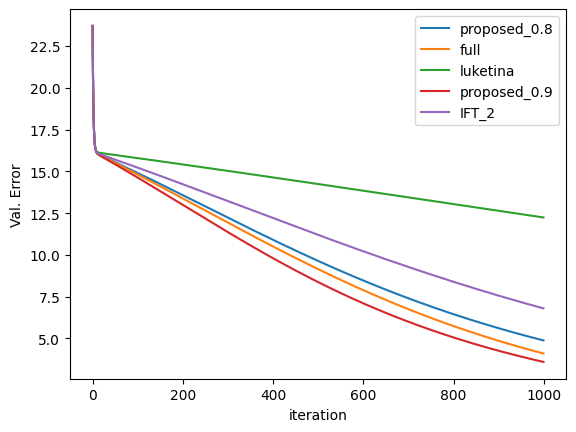

In [244]:
for k, v in val_losses.items():
    plt.plot(v, label=k)
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Val. Error')
plt.show()

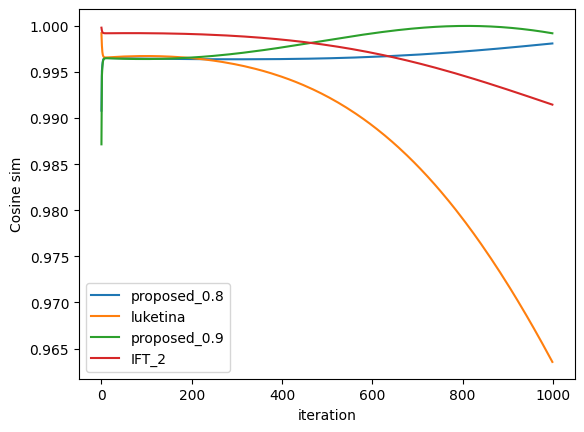

In [245]:
for k, grads in val_grads.items():
    if k == 'full':
        continue
    plt.plot([(g @ g_full) / (jnp.linalg.norm(g) * jnp.linalg.norm(g_full)) \
              for g, g_full in zip(grads, val_grads['full'])], label=k)
plt.legend()
plt.xlabel('iteration')
plt.ylabel('Cosine sim')
plt.show()

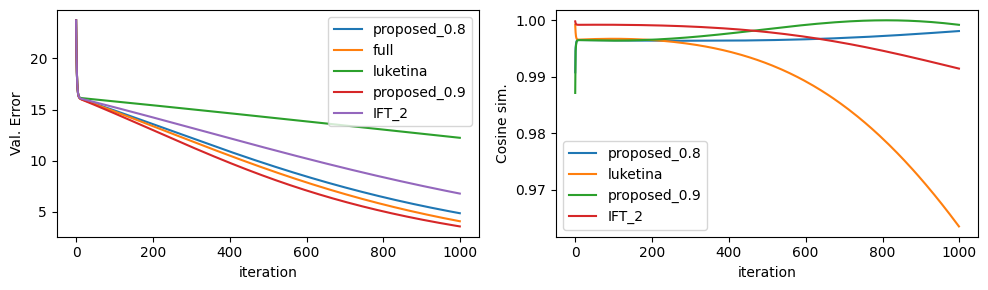

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

for k, v in val_losses.items():
    axes[0].plot(v, label=k)
axes[0].legend()
axes[0].set_xlabel('iteration')
axes[0].set_ylabel('Val. Error')


for k, grads in val_grads.items():
    if k == 'full':
        continue
    axes[1].plot([(g @ g_full) / (jnp.linalg.norm(g) * jnp.linalg.norm(g_full)) \
              for g, g_full in zip(grads, val_grads['full'])], label=k)
axes[1].legend()
axes[1].set_xlabel('iteration')
axes[1].set_ylabel('Cosine sim.')
plt.tight_layout()
# plt.savefig('toy_sin.pdf')
plt.show()
